# Phase 2: Prey Population Dynamics Analysis

## Goal
The objective of this notebook is to analyze the core population dynamics of a single species, `Zooplankton`, within the final Cellular Automata (CA) environment. We will:
1. Set up a dynamic environment where the food source (plankton) is governed by CA rules.
2. Spawn a large population of Zooplankton agents, with predators disabled.
3. Run the simulation using the high-performance, vectorized `SimulationManager`.
4. Collect and visualize data to analyze the emergent boom-and-bust cycle, which serves as a baseline for the full ecosystem.

### 1. Setup and Configuration

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.environment import Environment
from src.simulation.runner import setup_simulation
from src.utils.config_loader import load_fauna_config, load_sim_config
from src.simulation.simulation_manager import SimulationManager

print("Setup complete. Modules imported successfully.")

Setup complete. Modules imported successfully.


### 2. Isolate the Prey

To analyze the prey's dynamics in isolation, we load the standard configurations but programmatically disable the predators by setting their initial count to zero. This allows us to observe how the prey population behaves without predation pressure.

In [2]:
# Load the base configurations
sim_config = load_sim_config()
fauna_configs = load_fauna_config()

# --- HIGHLIGHT: Create a test-specific config to isolate prey ---
prey_only_sim_config = deepcopy(sim_config)
prey_only_sim_config["initial_small_fish_count"] = 0
prey_only_sim_config["initial_crab_count"] = 0
# Start with a higher prey count for a more dramatic boom-bust cycle
prey_only_sim_config["initial_zooplankton_count"] = 200 

print("--- Test Simulation Parameters ---")
print(f"Initial Zooplankton: {prey_only_sim_config['initial_zooplankton_count']}")
print(f"Initial Small Fish: {prey_only_sim_config['initial_small_fish_count']} (Disabled)")

--- Test Simulation Parameters ---
Initial Zooplankton: 200
Initial Small Fish: 0 (Disabled)


### 3. Simulation Run

This cell runs the simulation with only the prey active. We collect data on the prey population and the total amount of plankton at each tick.

In [3]:
# Data Collection Setup
history = []

print("Starting prey-only simulation...")

# Initialize the simulation with the modified config
env, initial_agents = setup_simulation(prey_only_sim_config, fauna_configs)
sim_manager = SimulationManager(env, initial_agents, fauna_configs)

# Main Loop
for tick in range(sim_config["simulation_ticks"]):
    env.update()
    sim_manager.update()
    sim_manager.cleanup()
    
    zoo_pop, _, _ = sim_manager.get_population_counts()
    
    history.append({
        "tick": tick + 1,
        "population": zoo_pop,
        "total_plankton": env.plankton.sum()
    })
    
    # Stop the simulation if the prey population collapses
    if zoo_pop == 0:
        print(f"Prey population collapsed at tick {tick + 1}.")
        break

print("Simulation finished.")

Starting prey-only simulation...
Simulation finished.


### 4. Data Analysis and Visualization

The plot below visualizes the relationship between the Zooplankton population and the available plankton over time, demonstrating the classic boom-and-bust cycle that occurs in the absence of predators.

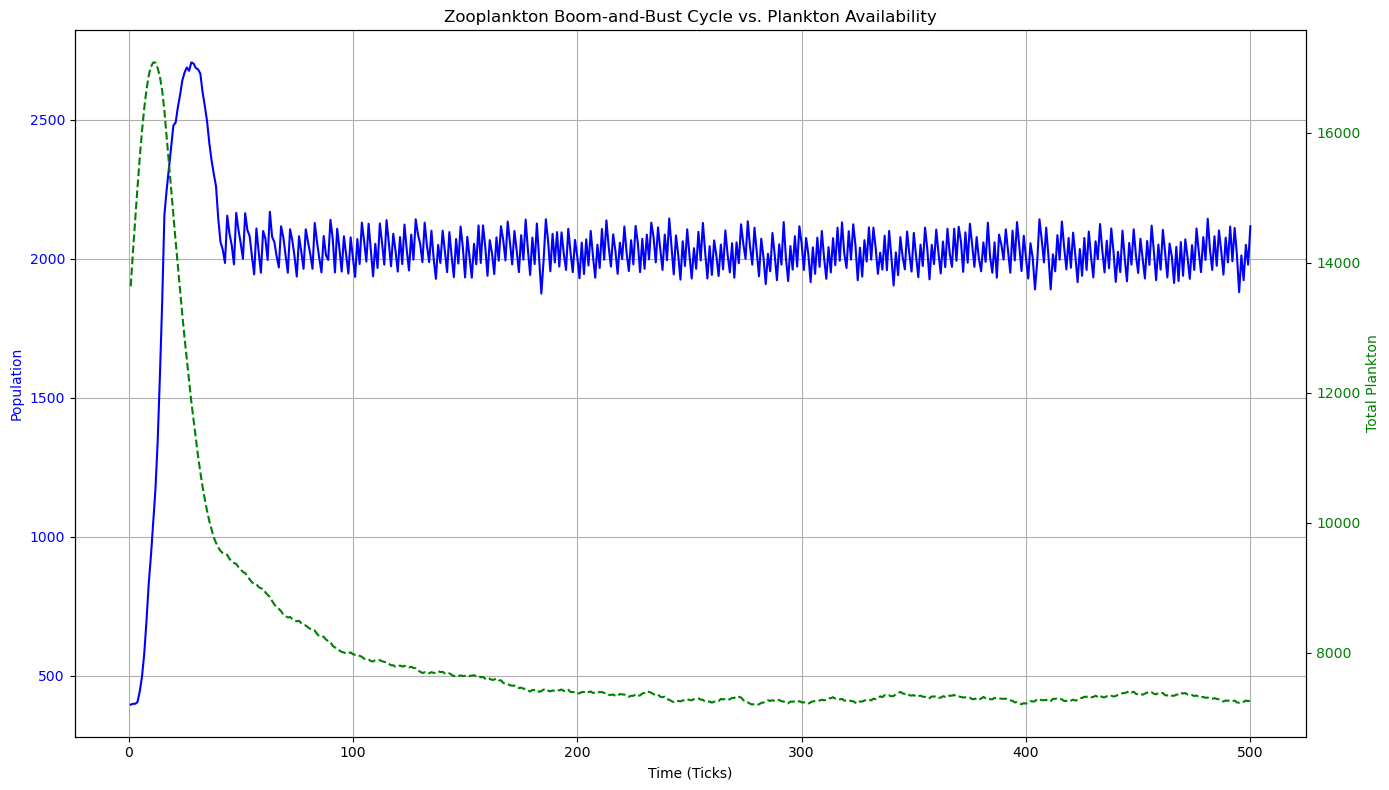

In [4]:
# Extract data from history
ticks = [h['tick'] for h in history]
population = [h['population'] for h in history]
total_plankton = [h['total_plankton'] for h in history]

# Create the plot with a dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(ticks, population, 'b-', label='Zooplankton Population')
ax1.set_xlabel('Time (Ticks)')
ax1.set_ylabel('Population', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Zooplankton Boom-and-Bust Cycle vs. Plankton Availability')
ax1.grid(True)

ax2 = ax1.twinx()  # Create a second y-axis for plankton
ax2.plot(ticks, total_plankton, 'g--', label='Total Plankton')
ax2.set_ylabel('Total Plankton', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.show()

### 5. Conclusion

The data clearly shows the classic **boom-and-bust cycle**, driven by the dynamic plankton environment and the prey's own internal population controls (like carrying capacity and disease).

1.  **Boom Phase:** The Zooplankton population grows exponentially, consuming the readily available plankton.
2.  **Resource Depletion:** The rapid population growth leads to a sharp decline in total plankton as it is consumed faster than the Cellular Automata rules can replenish it.
3.  **Bust Phase (Crash):** Once the plankton is scarce, mass starvation and disease occur, and the Zooplankton population crashes.
4.  **Recovery Potential:** After the crash, the plankton level begins to slowly recover, demonstrating the environment's self-regulating nature.

This outcome successfully validates the core mechanics governing the prey population. The system produces realistic ecological patterns, providing a solid and well-understood baseline before re-introducing predators and scavengers in the next notebook.